# SANS: Using CNN to predict model ID
We will utilize the zenodo [repository](https://zenodo.org/records/10119316) as our data for this project. We will download the dataset files in the `./data/` directory.

In [ ]:
%colors lightbg
%matplotlib inline

In [ ]:
import h5py
import fsspec
import torch
from torch import nn
import pickle
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim

## load data

In [ ]:
# ----------- RUN THIS CELL IF YOU WANT TO DOWNLOAD THE DATA SET -------------
#!curl -o train.h5 https://zenodo.org/records/10119316/files/train.h5
#!curl -o test.h5 https://zenodo.org/records/10119316/files/test.h5
#!curl -o val.h5 https://zenodo.org/records/10119316/files/val.h5

In [ ]:
# --------- TO DIRECTLY RUN DATA FROM THE REPO ------------
'''
train_url = "https://zenodo.org/records/10119316/files/train.h5"
test_url = "https://zenodo.org/records/10119316/files/test.h5"
val_url = "https://zenodo.org/records/10119316/files/val.h5"
remote_f = fsspec.open(train_url, mode="rb")
if hasattr(remote_f, "open"):
    remote_f = remote_f.open()'
'''

'\ntrain_url = "https://zenodo.org/records/10119316/files/train.h5"\ntest_url = "https://zenodo.org/records/10119316/files/test.h5"\nval_url = "https://zenodo.org/records/10119316/files/val.h5"\nremote_f = fsspec.open(train_url, mode="rb")\nif hasattr(remote_f, "open"):\n    remote_f = remote_f.open()\'\n'

In [ ]:
#train_file = h5py.File("./data/train.h5", "r")
#test_file = h5py.File("./data/test.h5", "r")
#val_file = h5py.File("./data/val.h5", "r")
#print(train_file.keys())

In [ ]:
#print(train_file['data'], train_file['target'])

In [ ]:
class H5Dataset(Dataset):
    def __init__(self, h5_path, transforms=None):
        self.h5_file = h5py.File(h5_path, "r")
        self.transform = transforms

    def __getitem__(self, index):
        sample = self.h5_file["data"][index]
        if self.transform is not None:
            sample = self.transform(sample)
        return (
            sample,
            int(self.h5_file["target"][index]),
        )

    def __len__(self):
        return self.h5_file["target"].size

In [ ]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((180, 180), antialias=True),
        torch.nn.ReLU(inplace=True),  # remove negative values if any
        torchvision.transforms.Lambda(lambda x: torch.log(x + 1.0)),
        torchvision.transforms.Lambda(
            lambda x: x / torch.max(x) if torch.max(x) > 0 else x
        ),
    ]
)
train_data = H5Dataset("./data/train.h5")
test_data = H5Dataset("./data/test.h5")
val_data = H5Dataset("./data/val.h5")

In [ ]:
print(len(train_data))

181531


### Plotting a typical 2D intensity array

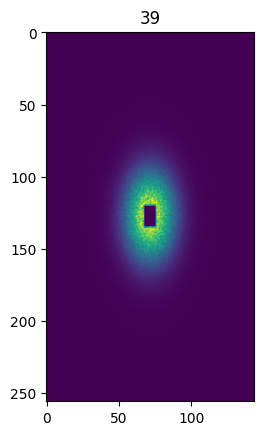

In [ ]:
idx = 537
psd_array = train_data[idx][0]
target = train_data[idx][1]
plt.figure()
plt.imshow(psd_array)
plt.title(target)
plt.show()

### exploring the model names

Manually add the `.pkl` files inside the directory `sas_helper/` as some of the files are too large to be uploaded on a GitHub repo. These files have been purposefully added to `.gitignore` due to this reason.

In [ ]:
with open("sas_helper/model_names.pkl", "rb") as pf:    #
    model_names = pickle.load(pf)
print(model_names)

{0: 'Adsorbed layer', 1: 'Barbell aniso', 2: 'Bcc paracrystal aniso', 3: 'Binary hard sphere', 4: 'Broad peak', 5: 'Capped cylinder aniso', 6: 'Core shell bicelle aniso', 7: 'Core shell bicelle elliptical aniso', 8: 'Core shell bicelle elliptical belt rough aniso', 9: 'Core shell cylinder aniso', 10: 'Core shell ellipsoid aniso', 11: 'Core shell parallelepiped aniso', 12: 'Core shell sphere', 13: 'Cylinder aniso', 14: 'Dab', 15: 'Ellipsoid aniso', 16: 'Elliptical cylinder aniso', 17: 'Fcc paracrystal aniso', 18: 'Flexible cylinder', 19: 'Fractal', 20: 'Fractal core shell', 21: 'Fuzzy sphere', 22: 'Gauss lorentz gel', 23: 'Gel fit', 24: 'Hollow cylinder aniso', 25: 'Hollow rectangular prism aniso', 26: 'Lamellar hg', 27: 'Lamellar hg stack caille', 28: 'Lamellar stack paracrystal', 29: 'Mass fractal', 30: 'Mono gauss coil', 31: 'Multilayer vesicle', 32: 'Parallelepiped aniso', 33: 'Pearl necklace', 34: 'Poly gauss coil', 35: 'Polymer micelle', 36: 'Raspberry', 37: 'Rectangular prism ani

In our case, the model name is given as

In [ ]:
model_names[39]

'Sphere'

### loading instrument parameters

In [ ]:
inst_params = {}
for partition in ["test", "train", "val"]:
    with open(f"sas_helper/inst_params_{partition}.pkl", "rb") as pf:
        inst_params[partition] = pickle.load(pf)

In [ ]:
inst_params['train'].shape

torch.Size([181531, 10])

In [ ]:
inst_params['train'][0]

tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0.])

We loaded all the instrument parameters inside the `inst_params` dictionary, with the corresponding partition as key. The 10 parameters that are one-hot encoded are:

In [ ]:
inst_params_names  = ['Lam_4.5', 'Lam_6.0', 'zdepth_0.001', 'zdepth_0.002', 'InstSetting_1', 'InstSetting_2', 'InstSetting_3', 'SlitSetting_1', 'SlitSetting_2', 'SlitSetting_3']
print(inst_params_names)

['Lam_4.5', 'Lam_6.0', 'zdepth_0.001', 'zdepth_0.002', 'InstSetting_1', 'InstSetting_2', 'InstSetting_3', 'SlitSetting_1', 'SlitSetting_2', 'SlitSetting_3']


- Lam = Lambda, wavelength of monochromatized neutrons in Angstroms. Two possible values [4.5, 6.0]
- zdepth = sample thickness, Two possible values [0.001, 0.002]
- InstSetting = Instrument setting. 3 possible values [1, 2, 3]
- SlitSetting = slit (collimation) setting, 3 possible values [1, 2, 3]

Again, variables are one-hot encoded. Order of columns matters. This means that case 0 (described above) was measured with a wavelength of 4.5, a sample thickness of 0.001, and a slit setting of 2. (check)

This matrix can be used as **input features** for the regression or classification task.


### pytorch dataloader
We will now create a dataloader from our train, test, and val datasets which can then directly be fed in their respective loops.

In [ ]:
train_dataloader = DataLoader(
    train_data,
    batch_size=32, # play with this also
    num_workers=1, #modify to your cpus available!
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    num_workers=1,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_data,
    batch_size=32,
    num_workers=1,
    shuffle=True,
)

In [ ]:
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)
val_iter = iter(val_dataloader)

## model

In the next cell, we will try to use a GPU if it is available. Otherwise, we will resort to the CPU.

In [ ]:
if torch.cuda.device_count() > 0:
    device = torch.device("cuda:0")
elif torch.mps.device_count() > 0:
    device = torch.device("mps:0")
else:
    device=torch.device("cpu")

Now, we will implement our model, containing various Convolution, pooling and fully connected layers.

In [ ]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers and batch normalization
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(0.5)

        # fully connected layers
        self.fc1 = nn.Linear(256 * 32 * 18, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 46)  # 46 output classes based on model_names.pkl

    def forward(self, x):
        x = x.unsqueeze(1)

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 256 * 32 * 18)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model = model()
model = model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

Let's use our model class and run a training loop using the class and our training dataset.

In [ ]:
weights = list(model.parameters())
print(model)
print(len(weights))

model(
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=147456, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=46, bias=True)
)
18


In [ ]:
epochs = 5
batch_size = 32
best_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    train_iter = iter(train_dataloader)

    num_batches = 0

    for batch_idx in range(len(train_dataloader)):
        # Zeroing the gradients
        optimizer.zero_grad()
        train_images, train_labels = next(train_iter)

        train_images = train_images.to(device)
        train_labels = train_labels.to(device)

        outputs = model(train_images)
        loss = loss_func(outputs, train_labels)

        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        num_batches += 1

        if batch_idx % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_dataloader)}], '
                  f'Loss: {loss.item():.4f}')

    # Calculate average loss for the epoch
    epoch_loss = running_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}] complete. Average loss: {epoch_loss:.4f}')

SAVE_PATH = './saved_models/saved_model.pth'
torch.save(model.state_dict(), SAVE_PATH)

Epoch [1/5], Batch [0/5673], Loss: 3.8599
Epoch [1/5], Batch [5/5673], Loss: 3.9826
Epoch [1/5], Batch [10/5673], Loss: 3.8599
Epoch [1/5], Batch [15/5673], Loss: 3.8287
Epoch [1/5], Batch [20/5673], Loss: 3.8171


KeyboardInterrupt: 

In [ ]:
print(f"Final loss: {loss.item():.4f}")

# to calculate accuracy
_, predicted = torch.max(outputs.data, 1)
total = train_labels.size(0)
correct = (predicted == train_labels).sum().item()
accuracy = 100 * correct / total

print(f"Training accuracy: {accuracy:.2f}%")


Final loss: 3.8217
Training accuracy: 0.00%
